In [1]:
import pylab as M, numpy as N
import ipyvolume as ipv

In [2]:
def write_fvolume(filename,d):
    F = open(filename,'w')

    head=N.zeros(64,dtype=N.int32)
    head[3:6]=d.shape
    head.tofile(F)
    d.astype(N.float32).flatten().tofile(F)

    F.close()

In [3]:
filehead = '../swc/Blue10_9-17-12_sec1_Neuron4.CNG'
swc=N.loadtxt(filehead+'.swc')
print(N.max(N.abs(swc[:,2:5])))
swc[:,0] -= 1
swc[:,6] -= 1 #because they start with 1 instead of 0
print(N.max(N.abs(swc[:,2:5])))
ipv.clear()
fig = ipv.figure(width=400, height=400)
s = ipv.scatter(swc[:, 2], swc[:, 3], swc[:, 4], marker='sphere', size=0.8)
ipv.show()

130.04
130.04


In [4]:
print(swc.shape,N.max(N.abs(swc[:,2:5])))

(222, 7) 130.04


In [5]:
n=64
rad = 40.
x = N.linspace(-rad, rad, n)
y = N.linspace(-rad, rad, n)
z = N.linspace(-rad, rad, n)
xv, yv,zv = N.meshgrid(x,y,z)
xyz = N.array([xv,yv,zv]).swapaxes(0,-1).reshape(n**3,3)
print(xv.shape)

(64, 64, 64)


In [6]:
print(xyz)

[[-40.         -40.         -40.        ]
 [-38.73015873 -40.         -40.        ]
 [-37.46031746 -40.         -40.        ]
 ...
 [ 37.46031746  40.          40.        ]
 [ 38.73015873  40.          40.        ]
 [ 40.          40.          40.        ]]


In [14]:
dist2neuron = 1e30+N.zeros(n**3,dtype=N.float)
dist2seg = N.zeros(n**3,dtype=N.float)
for seg in N.arange(1,swc.shape[0]):
    parent=int(swc[seg,6])
    #print(seg, parent)
    p1mp0 = xyz-swc[seg,2:5]
    p2mp0 = xyz-swc[parent,2:5]
    p2mp1= swc[seg,2:5]-swc[parent,2:5]
    dist2p1p2 = N.sum(p2mp1**2)
    dotty = N.dot(p1mp0,p2mp1)*N.dot(p2mp0,p2mp1)
    w = N.where(dotty >= 0.)
    if len(w) > 0:
        w=w[0]
        dist2p1 = N.sum(p1mp0[w,:]**2,axis=-1)
        dist2p2 = N.sum(p2mp0[w,:]**2,axis=-1)
        dist2seg[w] = N.minimum(dist2p1,dist2p2)
    w = N.where(dotty < 0.)
    if len(w) > 0:
        w=w[0]
        crossy = N.cross(p2mp1, p1mp0[w,:])
        dist2seg[w] = N.sum(crossy**2,axis=-1)/dist2p1p2
    
    dist2seg = N.sqrt(dist2seg)/swc[seg,5]
    
    dist2neuron = N.minimum(dist2neuron,dist2seg)
    
dist2neuron = dist2neuron.reshape(n,n,n)

0.0233017271575883 10.196729699841002


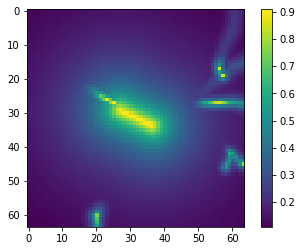

In [15]:
print(N.min(dist2neuron),N.max(dist2neuron))

M.imshow(1./(1.+dist2neuron.reshape(n,n,n)[int(n/2),:,:])); M.colorbar()

In [16]:
ipv.quickvolshow(1./(dist2neuron.reshape(n,n,n)+1.))

In [11]:
write_fvolume(filehead+'.dens',1./(dist2neuron.reshape(n,n,n)+1.))